# Time series forecasting 

A number of time series future forecasting methods will be explored here on monthly sales data. The techniques and methods that will be explored include:
+ Moving average
+ Exponential smoothing
+ Holt-Winter's Seasonal Smoothing model
+ SARIMA
+ Prophet

The dataset used is the sales data from the store item demand forecasting challenge on Kaggle, found here: https://www.kaggle.com/c/demand-forecasting-kernels-only

This dataset includes sales per store, per item, per day. To simplify, sales will be aggregated to obtain total number of all sales per month.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('data/sales_data.csv')
data['date'] = pd.to_datetime(data['date'])

#represent day in date field as its first day
data['date'] = data['date'].dt.year.astype('str') + '-' + data['date'].dt.month.astype('str') + '-01'
data['date'] = pd.to_datetime(data['date'])

#groupby date and sum the sales
data = data.groupby('date')['sales'].agg('sum').reset_index()
data = data[['date','sales']].set_index('date')
#.reset_index()
data.head()

,sales
date,
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242


## Data Exploration

In [3]:
data.shape

(60, 1)

In [4]:
data.isnull().sum()

sales    0
dtype: int64

In [5]:
data.dtypes

sales    int64
dtype: object

### Is the data stationary?

Stationarity is an important characteristic of time series. A time series is said to be stationary if its statistical properties do not change over time. In other words, it has constant mean and variance, and covariance is independent of time.

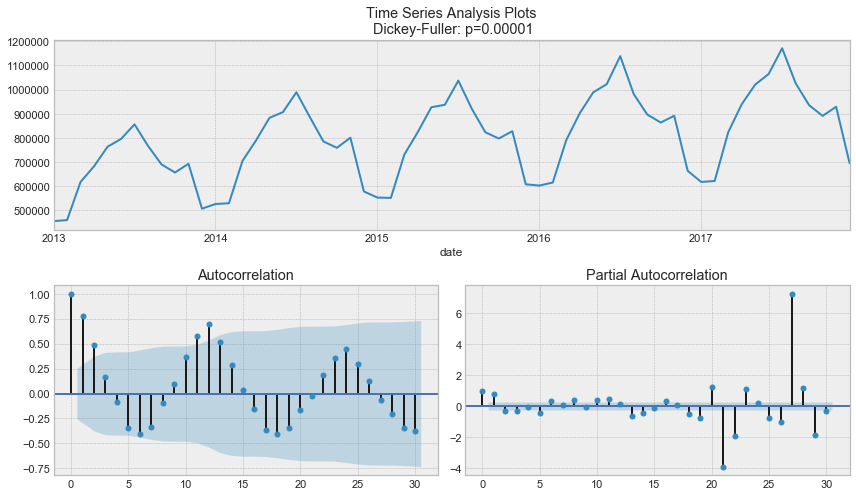

In [6]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.sales, lags=30)

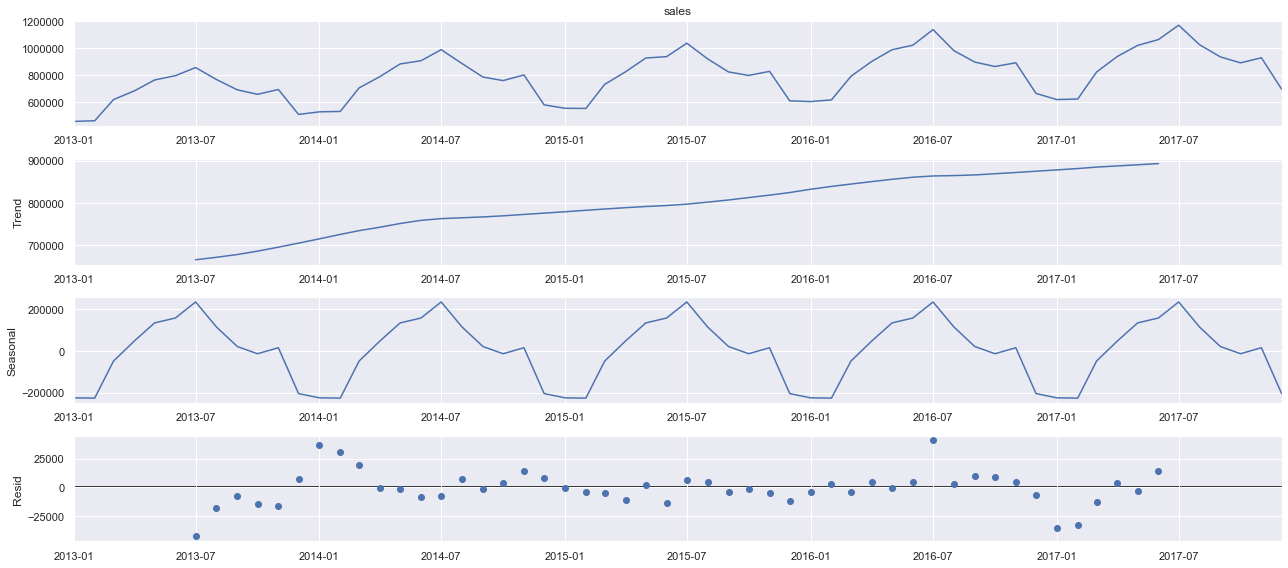

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data.sales, model='additive')
fig = decomposition.plot()
plt.show()

The above suggests that the data is not stationary, so may require transforming for the moving average and exponential smoothing methods. But statistical tests - Dickey-Fuller and KPSS - will be implemented to obtain a more rigourous answer.

In [8]:
from statsmodels.tsa.stattools import adfuller

print("Results of Dickey-Fuller Test")
dftest = sm.tsa.stattools.adfuller(data.sales, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

Results of Dickey-Fuller Test
Test statistic = -5.248
P-value = 7.026495391574649e-06
Critical values :
	1%: -3.5745892596209488 - The data is  stationary with 99% confidence
	5%: -2.9239543084490744 - The data is  stationary with 95% confidence
	10%: -2.6000391840277777 - The data is  stationary with 90% confidence


In [9]:
from statsmodels.tsa.stattools import kpss

#KPSS function
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    print('Test Statistics = {}'.format(kpss_output[0]))
    print('P-value = {}'.format(kpss_output[1]))
    print('Lags used = {}'.format(kpss_output[2]))
    print("Critical values :")
    for k, v in kpsstest[3].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v < kpss_output[0] else "", 100-float(k[:-1])))
    
kpss_test(data.sales)

Results of KPSS Test:
Test Statistics = 0.6304878487303728
P-value = 0.019864741024511565
Lags used = 11.0
Critical values :
	10%: 0.347 - The data is not stationary with 90.0% confidence
	5%: 0.463 - The data is not stationary with 95.0% confidence
	2.5%: 0.574 - The data is not stationary with 97.5% confidence
	1%: 0.739 - The data is  stationary with 99.0% confidence


The above returns conflicting answers. But having experimented with both transforming and not transforming the data, it was found that the models performed much better when the data was assumed to be stationary.

If, as shown by the upward trend in the decomposition, te data was taken as non-stationary, removal of the trend could involve various methods, for example differencing, where the difference of consecutive terms in the series is computed. Differencing is typically performed to get rid of the varying mean.

In [10]:
#train-test split
train = data[:-6]
test = data[-6:]

## Various methods to predict future daily energy consumption

### Moving Average

Moving average can be used to analyse the dataset and how it changes over time. This can also be used as method of data preparation to create a smoothed version of the original dataset

Furthermore, the moving average value can be used directly to make predictions. It is a naive model. The moving average model for predictions can easily be used in a walk-forward manner. As new observations are made available (e.g. daily), the model can be updated and a prediction made for the next day. 

Below, firstly moving average with different windows will be explored as a method to analyse the dataset and consider for smoothing purposes. Then, is the moving average model will be used to make future predictions for this dataset in a walk-forward manner.

#### For data exploration and smoothing

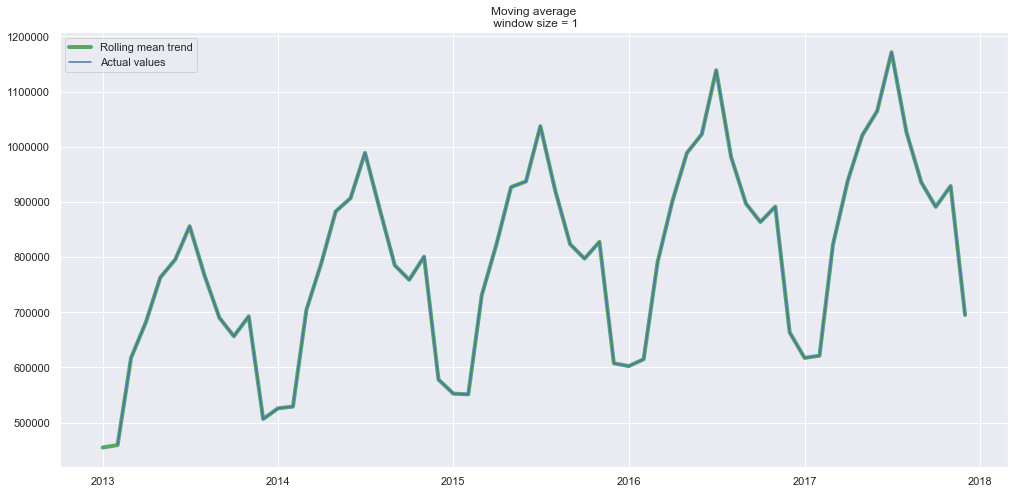

In [11]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', linewidth=4, label='Rolling mean trend')
    
    #plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#smooth by previous 1 month
plot_moving_average(data, 1)

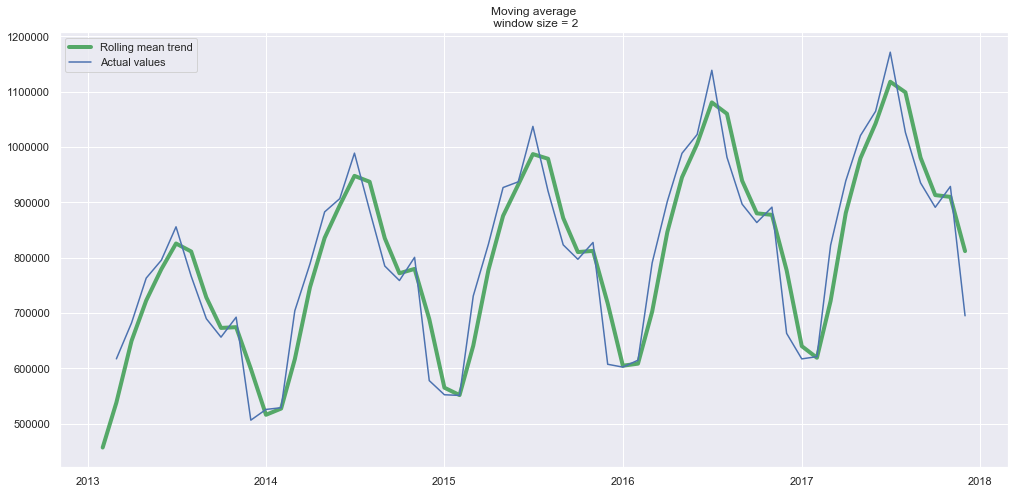

In [12]:
#smooth by previous 2 months
plot_moving_average(data, 2)

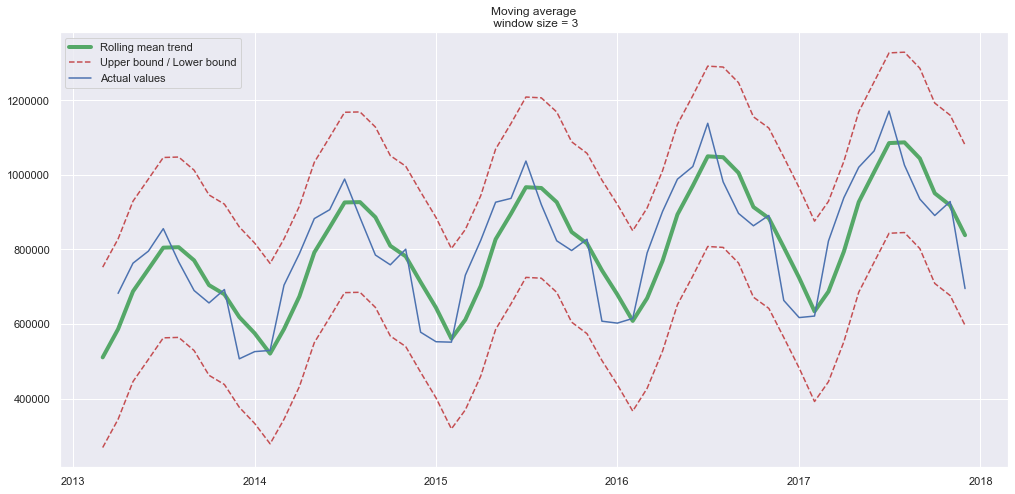

In [13]:
#smooth by previous quarter (3 months)
plot_moving_average(data, 3, plot_intervals=True)

#### For predictions

Test MSE: 22780777218.893
Test RMSE: 150933.022


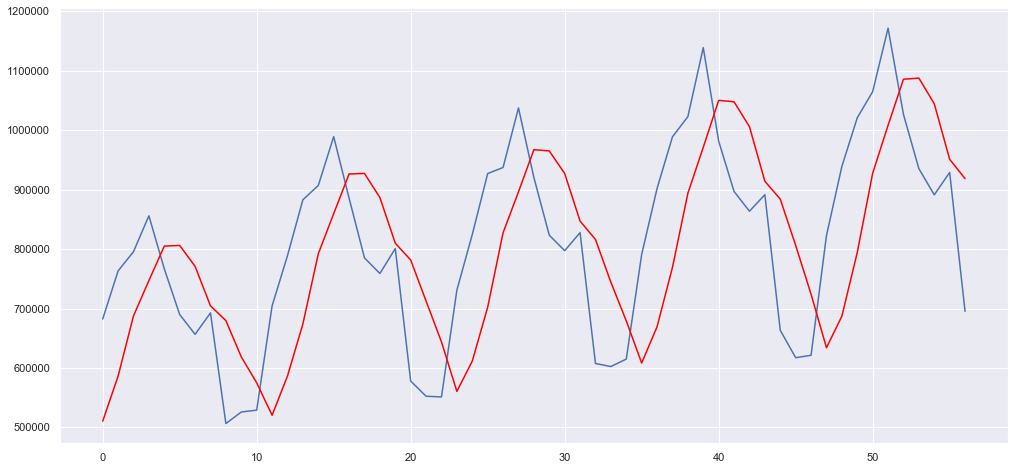

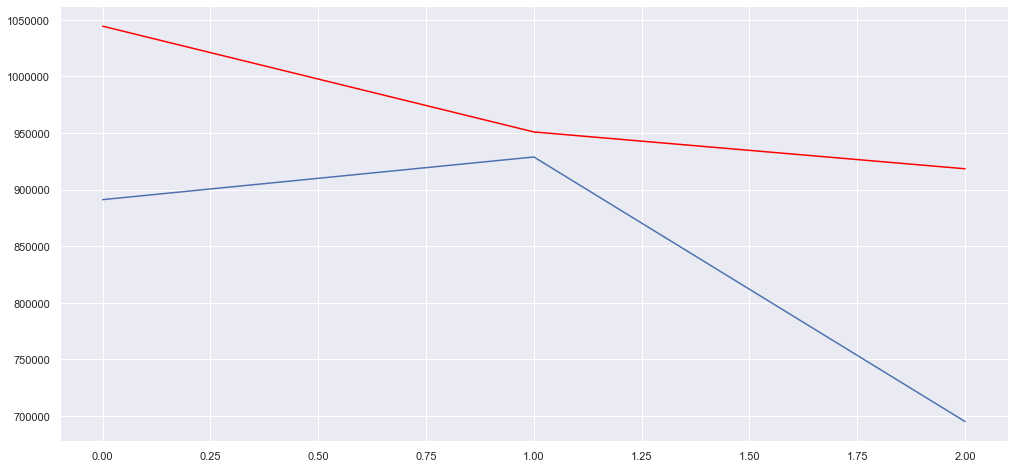

In [14]:
from pandas import read_csv
from numpy import mean
from sklearn.metrics import mean_squared_error

X = data.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()

#walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % np.sqrt(error))

#plot
plt.figure(figsize=(17,8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
#zoom plot
plt.figure(figsize=(17,8))
plt.plot(test[-3:])
plt.plot(predictions[-3:], color='red')
plt.show()

### Exponential Smoothing

Exponential smoothing uses a similar logic to moving average, but this time a different decreasing weight is assigned to each observation. In other words, less importance is given to observations moving further from the present.

Two versions will be explored: 
+ Single exponential smoothing (SES) - this is a time series forecasting method for univariate data without a trend or seasonality (although for this dataset the assumption of trend holds, seasonality is more questionable, but will be explored here for learning reasons). It requires a single parameter, alpha (a), also called the smoothing factor or smoothing coefficient. This parameter controls the rate at which the influence of the observations at prior time steps decay exponentially. Alpha is often set to a value between 0 and 1. Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction. This is recommended for use when there are few data points, irregular data, no seasonality or trend.
+ Double exponential smoothing - this is an extension to SES that explicitly adds support for trends in the univariate time series. In addition to the alpha parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend called beta (b). The method supports trends that change in different ways: an additive (Double Exponential Smoothing with a linear trend, also called Holt's linear trend model) and a multiplicative (Double Exponential Smoothing with an exponential trend), depending on whether the trend is linear or exponential respectively. For longer range (multi-step) forecasts, the trend may continue on unrealistically. As such, it can be useful to dampen the trend over time. Dampening means reducing the size of the trend over future time steps down to a straight line (no trend), which can be done additively (dampening the trend linearly) or multiplicatively (dampening the trend exponentially). Hyperparameters include: alpha (smoothing factor for the level), beta (smoothing factor for the trend), trend type (additive or multiplicative), dampen type (additive or multiplicative), phi (damping coefficient).

#### Single exponential smoothing

In [15]:
def exponential_smoothing(series, alpha):

    result = [series[0]] #first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

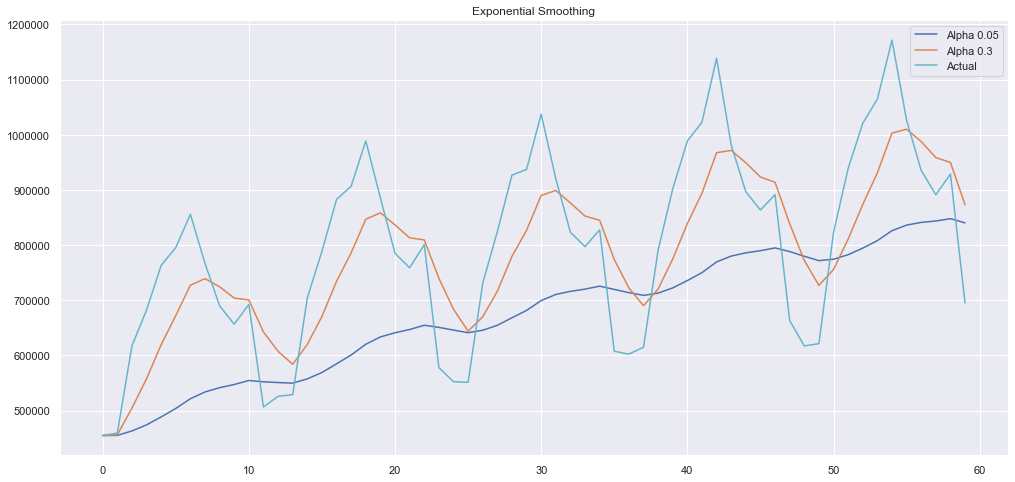

In [16]:
plot_exponential_smoothing(data.sales, [0.05, 0.3])

#### For prediction

Test MSE for alpha=1.0: 35769809884.000
Test RMSE for alpha=1.0: 189129.083

Test MSE for alpha=0.2: 22570062154.416
Test RMSE for alpha=0.2: 150233.359

Test MSE for alpha=0.5: 23733533346.275
Test RMSE for alpha=0.5: 154056.916


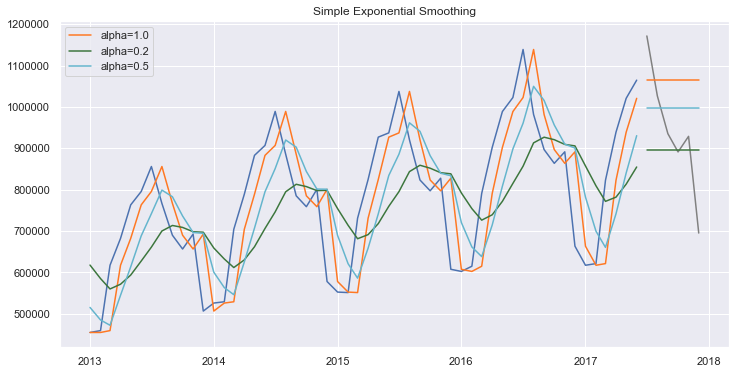

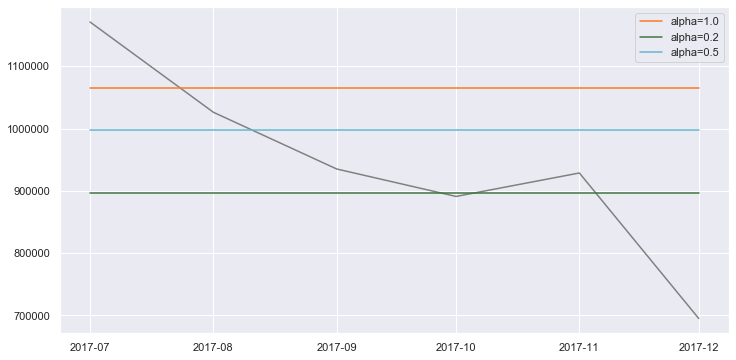

In [17]:
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import numpy as np
#plt.style.use('Solarize_Light2')

train = data[0:-6]
test = data[-6:]
pred = test.copy()

model = SimpleExpSmoothing(np.asarray(train))

fit1 = model.fit()
pred1 = fit1.forecast(6)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(6)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(6)

error1 = mean_squared_error(test, pred1)
error2 = mean_squared_error(test, pred2)
error3 = mean_squared_error(test, pred3)
print('Test MSE for alpha=1.0: %.3f' % error1)
print('Test RMSE for alpha=1.0: %.3f' % np.sqrt(error1))
print('\nTest MSE for alpha=0.2: %.3f' % error2)
print('Test RMSE for alpha=0.2: %.3f' % np.sqrt(error2))
print('\nTest MSE for alpha=0.5: %.3f' % error3)
print('Test RMSE for alpha=0.5: %.3f' % np.sqrt(error3))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.legend();

#### Double exponential smoothing

In [18]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

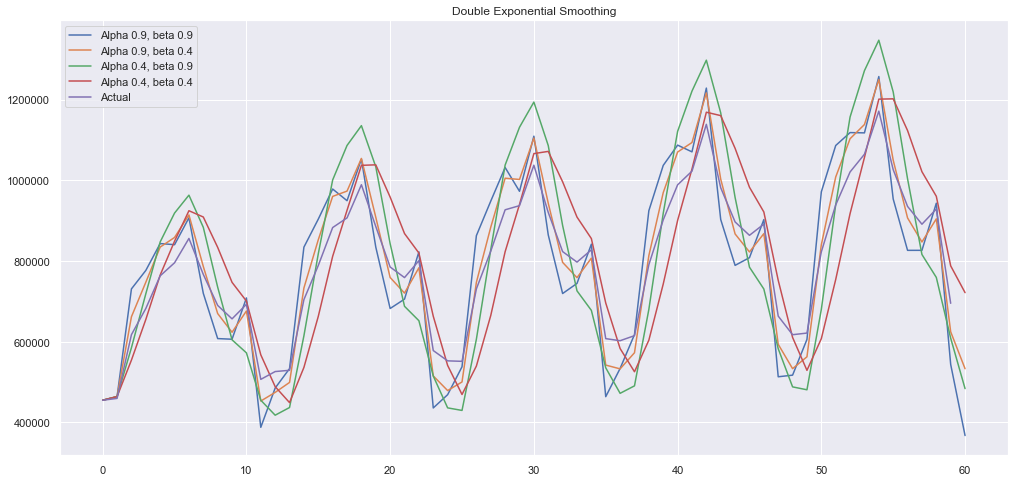

In [19]:
plot_double_exponential_smoothing(data.sales, alphas=[0.9, 0.4], betas=[0.9, 0.4])

#### For prediction - Holt's Linear Smoothing

This is recommended for use when there is a trend in the data but no seasonality. This would be the wrong case to use this on as (as shown above) the data does not have a trend, but does display seasonality. However, it will be implemented for learning purposes.

Test MSE for alpha=0.3, beta=0.05: 24364391863.043
Test RMSE for alpha=0.3, beta=0.05: 156090.973

Test MSE for alpha=1.0, beta=0.0: 52915411310.438
Test RMSE for alpha=1.0, beta=0.0: 230033.500

Test MSE for alpha=0.3, beta=0.2: 30518994757.075
Test RMSE for alpha=0.3, beta=0.2: 174696.865


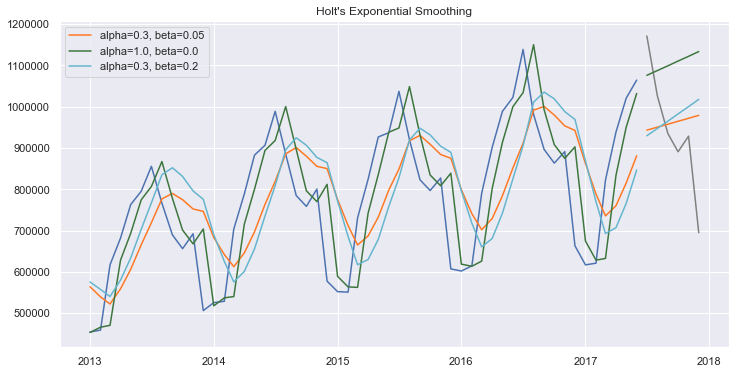

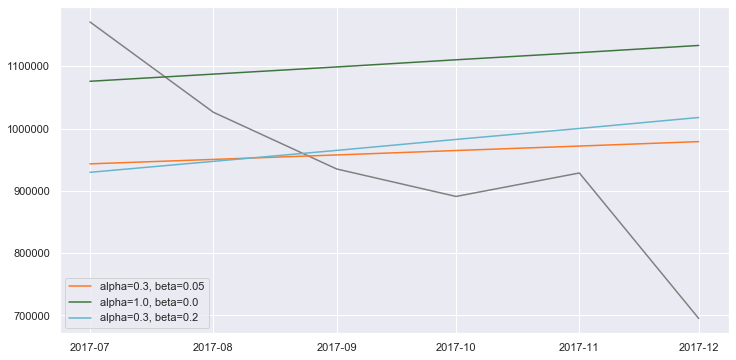

In [20]:
model = Holt(np.asarray(train))

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(6)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(6)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(6)

error1 = mean_squared_error(test, pred1)
error2 = mean_squared_error(test, pred2)
error3 = mean_squared_error(test, pred3)
print('Test MSE for alpha=0.3, beta=0.05: %.3f' % error1)
print('Test RMSE for alpha=0.3, beta=0.05: %.3f' % np.sqrt(error1))
print('\nTest MSE for alpha=1.0, beta=0.0: %.3f' % error2)
print('Test RMSE for alpha=1.0, beta=0.0: %.3f' % np.sqrt(error2))
print('\nTest MSE for alpha=0.3, beta=0.2: %.3f' % error3)
print('Test RMSE for alpha=0.3, beta=0.2: %.3f' % np.sqrt(error3))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.legend();

#### For prediction - Double Exponential Smoothing, Multiplicative (with and without dampening)

This is recommended for use when the data has a trend (not so for this data, but using for learning purposes).

Test MSE: 43847310980.855
Test RMSE: 209397.495

Test MSE for damped=True: 44927371557.410
Test RMSE for damped=True: 211960.778


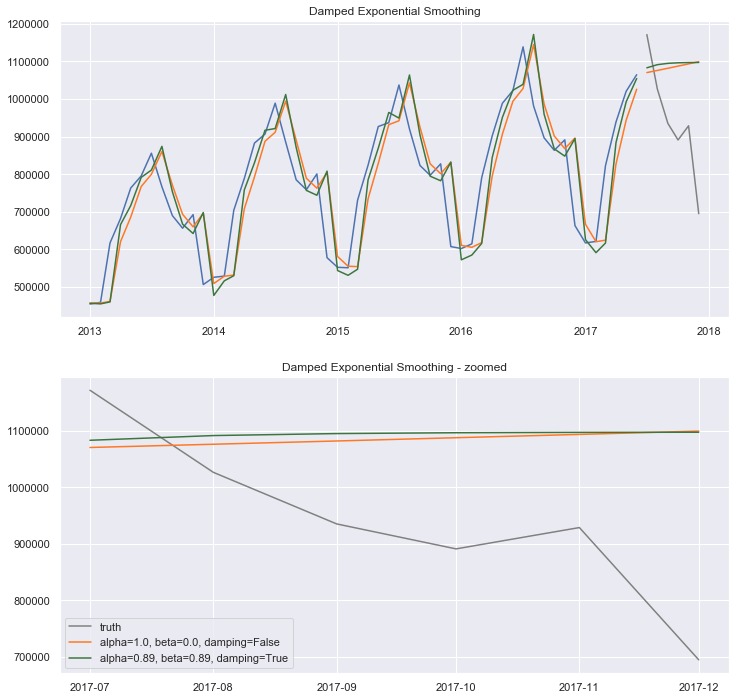

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

model = ExponentialSmoothing(np.asarray(train), trend='mul', seasonal=None)
model2 = ExponentialSmoothing(np.asarray(train), trend='mul', seasonal=None, damped=True)

fit1 = model.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(6)
pred2 = fit2.forecast(6)

error1 = mean_squared_error(test, pred1)
error2 = mean_squared_error(test, pred2)
print('Test MSE: %.3f' % error1)
print('Test RMSE: %.3f' % np.sqrt(error1))
print('\nTest MSE for damped=True: %.3f' % error2)
print('Test RMSE for damped=True: %.3f' % np.sqrt(error2))

fig, ax = plt.subplots(2, figsize=(12, 12))
ax[0].plot(train.index, train.values)
ax[0].plot(test.index, test.values, color="gray", label="truth")
#ax[1].plot(train.index[300:], train.values[300:])
ax[1].plot(test.index, test.values, color="gray", label="truth")
for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    ax[0].plot(train.index, f.fittedvalues, color=c)
    #ax[1].plot(train.index[300:], f.fittedvalues[300:], color=c)
    ax[0].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
    ax[1].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
ax[0].set_title("Damped Exponential Smoothing");
ax[1].set_title("Damped Exponential Smoothing - zoomed");
plt.legend();

As is clear from the above (and was anticipated as this dataset does not satisfy the assumptions of each), these smoothing methods do not perform very well in forecasting future daily energy consumption. The main issue is the seasonal component of the data.

## Seasonal considerations

### Seasonal Decomposition

Seasonality is an important consideration when modelling time series. Seasonality is a particularly endemic feature of weather data, and so of other data linked to the weather in some way. For example, when considering energy consumption it is anticipated that when the temperature drops during the winter months especially, energy consumption in the form of heating will increase. Seasonality may also be linked to other seemingly unconnected topics of consideration, for example, holidays may display a seasonal element - perhaps people are more likely to go on holiday during certain points of the year, which creates a seasonal element to the time series.

When seasonality is not accounted for, one risks erroneous forecasts of the data. While one could forecast a mean value for a particular time series, the peaks and valleys around that mean affect the forecasts for that time series significantly.

The idea beneath seasonal decomposition is to state that any series can be decomposed into a sum (or a product) of 3 components: a trend, a seasonal component, and residuals.

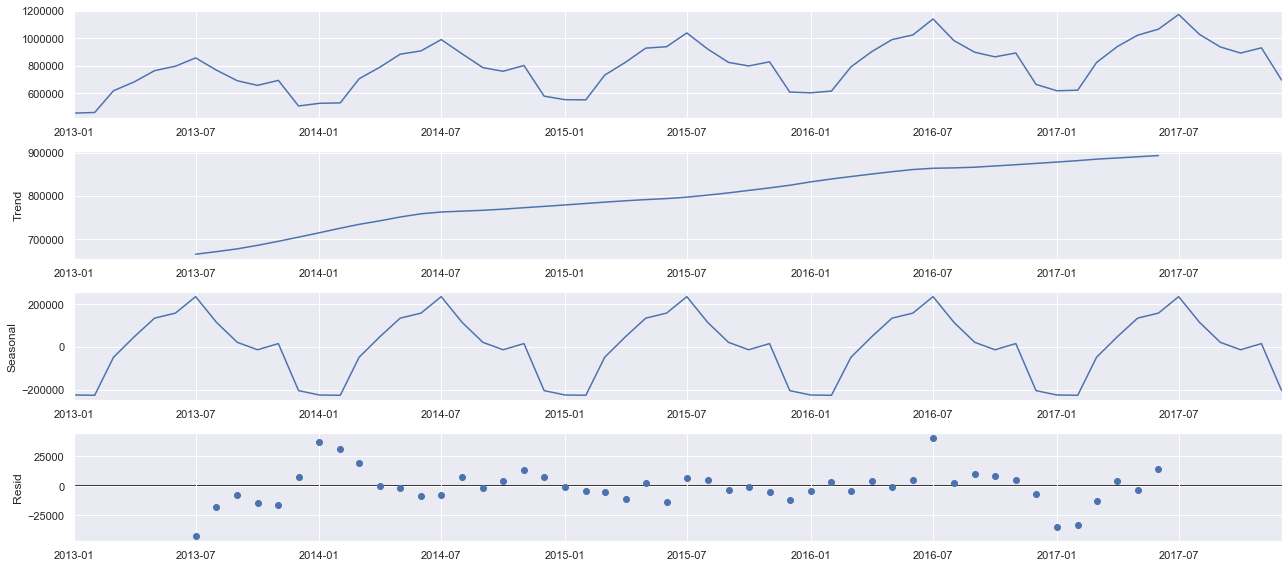

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

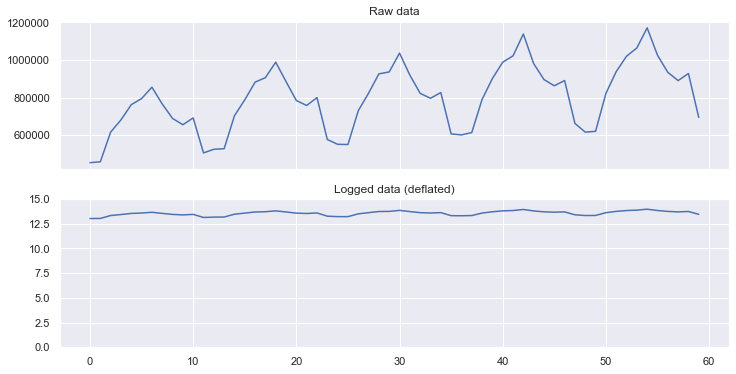

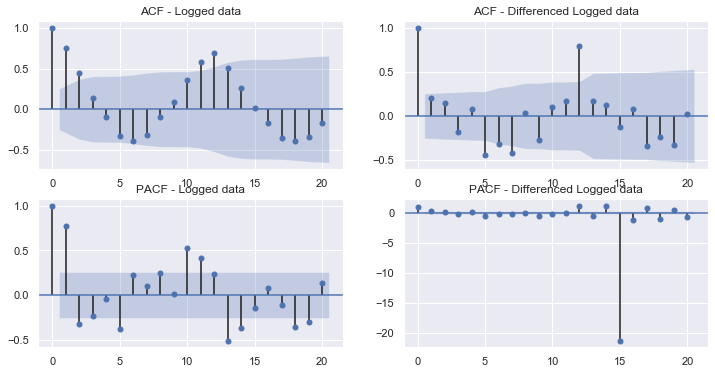

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))
ax[0].plot(data.values);
ax[0].set_title("Raw data");
ax[1].plot(np.log(data.values));
ax[1].set_title("Logged data (deflated)");
ax[1].set_ylim(0, 15);

fig, ax = plt.subplots(2, 2, figsize=(12,6))
first_diff = (np.log(data)- np.log(data).shift()).dropna()
ax[0, 0] = plot_acf(np.log(data), ax=ax[0, 0], lags=20, title="ACF - Logged data")
ax[1, 0] = plot_pacf(np.log(data), ax=ax[1, 0], lags=20, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=20, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=20, title="PACF - Differenced Logged data")

In [24]:
print(" > Is the data stationary ?")
print("Results of Dickey-Fuller Test")
dftest = sm.tsa.stattools.adfuller(data, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Results of Dickey-Fuller Test
Test statistic = -5.248
P-value = 7.026495391574649e-06
Critical values :
	1%: -3.5745892596209488 - The data is  stationary with 99% confidence
	5%: -2.9239543084490744 - The data is  stationary with 95% confidence
	10%: -2.6000391840277777 - The data is  stationary with 90% confidence




#### Holt-Winter's Seasonal Smoothing model

Holt-Winter’s model has several parts: a level, a trend, and in the case of a seasonal smoothing, a seasonal component.

Test MSE: 43847310980.855
Test RMSE: 209397.495

Test MSE for damped=True: 2951916243.564
Test RMSE for damped=True: 54331.540


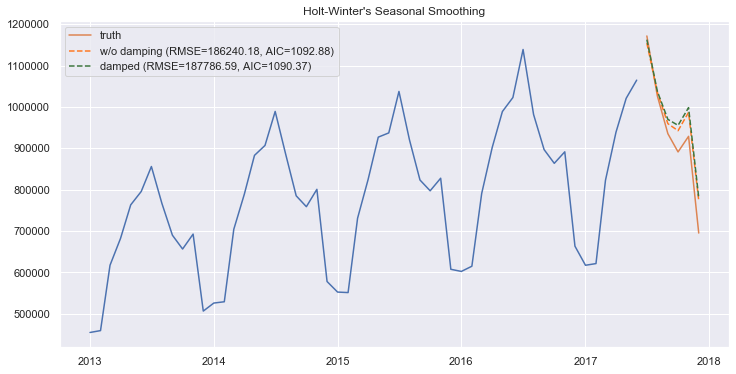

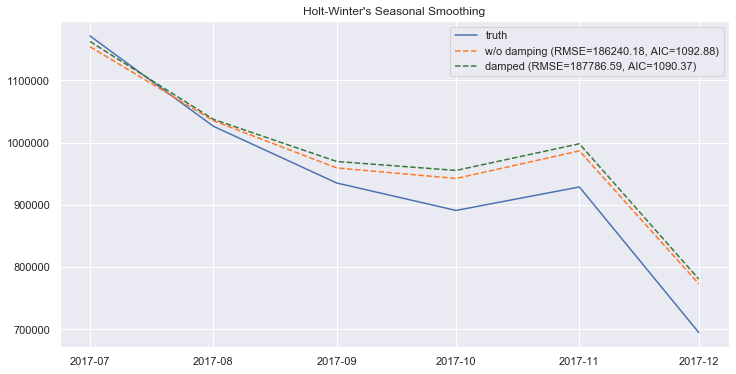

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = data[:-6]
test = data[-6:]

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(6)
fit2 = model2.fit()
pred2 = fit2.forecast(6)

error1 = mean_squared_error(test, pred1)
error2 = mean_squared_error(test, pred2)
print('Test MSE: %.3f' % error1)
print('Test RMSE: %.3f' % np.sqrt(error1))
print('\nTest MSE for damped=True: %.3f' % error2)
print('Test RMSE for damped=True: %.3f' % np.sqrt(error2))

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

This is an improvement; by accounting for seasonality, Holt-Winter's seasonal smoothing model displays more or a pattern that resembles energy consumption over time. However, it is not a very accurate prediction as the fluctuations wildly deviate from those of the true fluctuating pattern.

### SARIMA

Next, ARIMA models will be used. These are a general class of models to forecast stationary time series. ARIMA models are made of three parts:
+ A weighted sum of lagged values of the series (Auto-regressive (AR) part)
+ A weighted sum of lagged forecasted errors of the series (Moving-average (MA) part)
+ A difference of the time series (Integrated (I) part)

An ARIMA model is often noted ARIMA(p, d, q), and SARIMA is noted ARIMA (p, d, q)x(P, D, Q), with p = non-seasonal AR order, d = non-seasonal differencing, q = non-seasonal MA order, P = seasonal AR order, D = seasonal differencing, Q = seasonal MA order, and S = time span of repeating seasonal pattern.

AR (p and P) is the number of autoregressive terms, i.e. the number of observations from past time values used to forecast future values. e.g. if the value of p is 2, then this means that two previous time observations in the series are being used to forecast the future trend.
Differencing (d and D) refers to the number of differences needed to make the time series stationary (i.e. one with a constant mean, variance, and autocorrelation). For instance, if d = 1, then it means that a first-difference of the series must be obtained to transform it into a stationary one. MA (q and Q) represents the moving average of the previous forecast errors in our model, or the lagged values of the error term. As an example, if q has a value of 1, then this means that we have one lagged value of the error term in the model.

To determine all these parameters, the ACF and PACF plots, will provide guidelines for a range of reasonable values for parameters. 

AIC (Akaike information criterion) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. The lower the AIC value, the better.

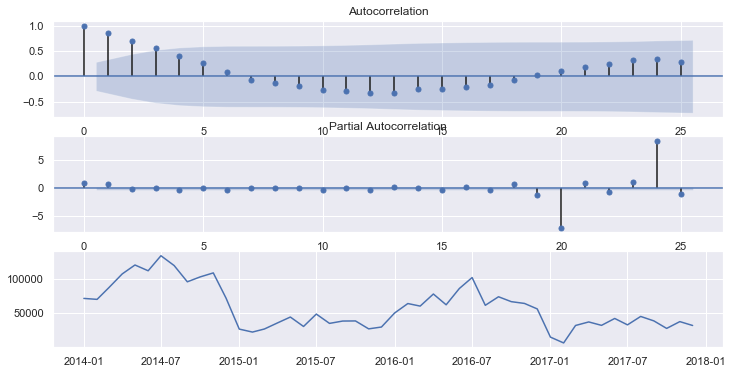

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(3, figsize=(12,6))
x = (data.sales.dropna() - data.sales.dropna().shift(12)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

#### Hyperparameter tuning of SARIMA

In [27]:
#set initial values and some bounds
ps = range(0, 12)
d = 1
qs = range(0, 8)
Ps = range(0, 12)
D = 1
Qs = range(0, 8)
s = 12

#create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

#train many SARIMA models to find the best set of parameters, return df with params and corresponding AIC
def optimize_SARIMA(parameters_list, d, D, s):
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = sm.tsa.statespace.SARIMAX(train.sales, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    
    #sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(train.sales, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                         SARIMAX Results                                          
Dep. Variable:                                      sales   No. Observations:                   54
Model:             SARIMAX(2, 1, 7)x(0, 1, [1, 2, 3], 12)   Log Likelihood                -431.872
Date:                                    Tue, 14 Apr 2020   AIC                            889.744
Time:                                            02:08:43   BIC                            912.021
Sample:                                        01-01-2013   HQIC                           897.856
                                             - 06-01-2017                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1256      0.073    -15.507      

In [28]:
print(best_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1256      0.073    -15.507      0.000      -1.268      -0.983
ar.L2         -0.9681      0.120     -8.041      0.000      -1.204      -0.732
ma.L1          1.0353      0.171      6.051      0.000       0.700       1.371
ma.L2          0.9455      0.221      4.269      0.000       0.511       1.379
ma.L3         -0.0026      0.212     -0.012      0.990      -0.419       0.413
ma.L4         -0.0077      0.207     -0.037      0.970      -0.414       0.398
ma.L5          0.0039      0.161      0.024      0.981      -0.311       0.319
ma.L6          0.0102      0.143      0.071      0.943      -0.271       0.291
ma.L7          0.0036      0.138      0.026      0.979      -0.267       0.274
ma.S.L12       0.1526      0.204      0.747      0.455      -0.248       0.553
ma.S.L24       0.0323      0.050      0.643      0.5

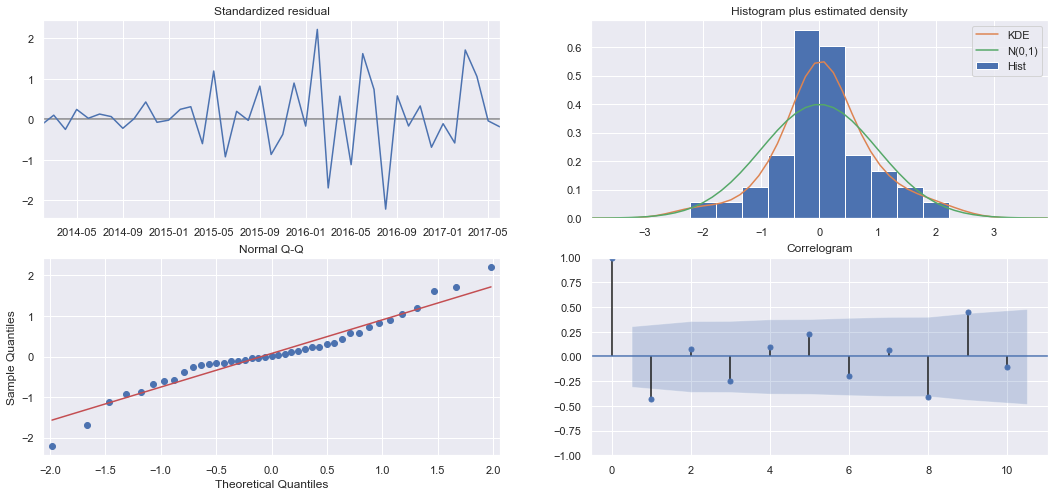

In [29]:
best_model.plot_diagnostics(figsize=(18, 8))
plt.show()

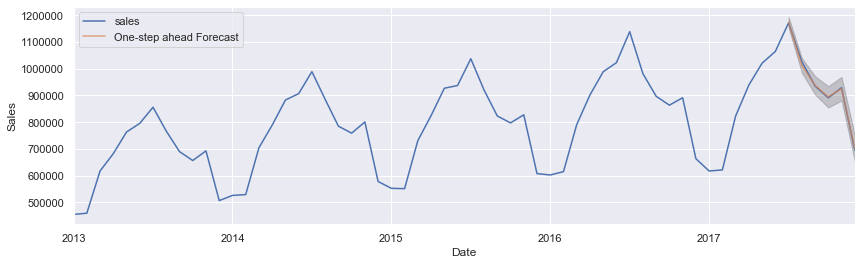

In [30]:
pred = best_model.get_prediction(start=pd.to_datetime('2017-07-01'), end=pd.to_datetime('2017-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = data.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [31]:
y_forecasted = pred.predicted_mean
y_truth = test.sales
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 48673872.2
The Root Mean Squared Error is 6976.67


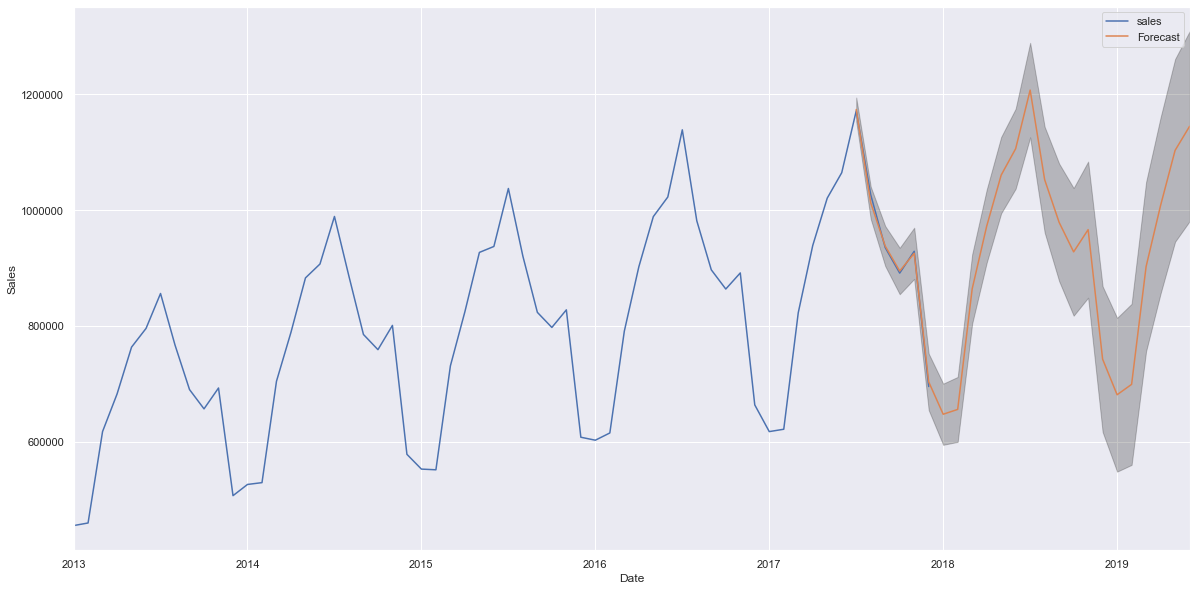

In [33]:
pred_uc = best_model.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = data.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [43]:
pred_uc.predicted_mean.round()

2017-07-01    1173818.0
2017-08-01    1012668.0
2017-09-01     937947.0
2017-10-01     894738.0
2017-11-01     925373.0
2017-12-01     703263.0
2018-01-01     647300.0
2018-02-01     655643.0
2018-03-01     863849.0
2018-04-01     972069.0
2018-05-01    1060419.0
2018-06-01    1106111.0
2018-07-01    1207362.0
2018-08-01    1052668.0
2018-09-01     978800.0
2018-10-01     927810.0
2018-11-01     966247.0
2018-12-01     742487.0
2019-01-01     680961.0
2019-02-01     698922.0
2019-03-01     902372.0
2019-04-01    1008098.0
2019-05-01    1103140.0
2019-06-01    1144741.0
Freq: MS, dtype: float64

### FB Prophet

Prophet uses a decomposable time series model with three main model components: growth, seasonality and holidays. They are combined using the equation:

y(t) = g(t) + s(t) + h(t) + e(t),

where g(t) represents the growth function which models non-periodic changes, s(t) represents periodic changes due to weekly or yearly seasonality, h(t) represents the effects of holidays, and e(t) represents the error term. Such decomposable time series are very common in forecasting and later in the article we will see how to tune each component of the above equation.

In [69]:
import pandas as pd

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import warnings
warnings.filterwarnings("ignore")

In [70]:
df_prophet = data.reset_index()
df_prophet = df_prophet[['date', 'sales']].rename(columns={'date':'ds', 'sales':'y'})
df_prophet.head()

,ds,y
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


In [71]:
train = df_prophet[:-6]
test = df_prophet[-6:]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


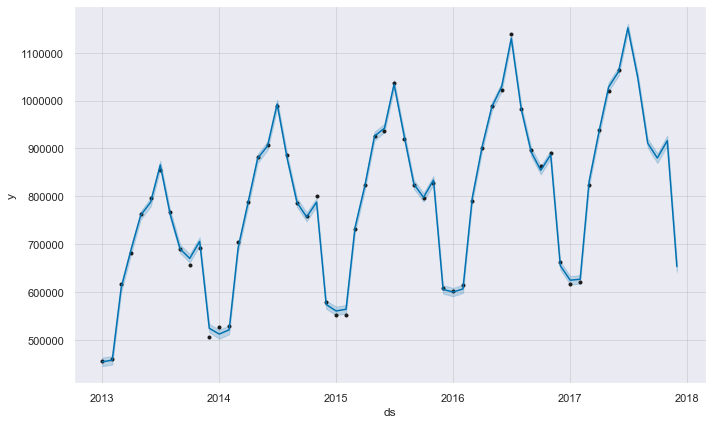

In [72]:
#fit prophet model
m = Prophet(seasonality_mode='multiplicative')
m.fit(train)
future = m.make_future_dataframe(periods=6, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)

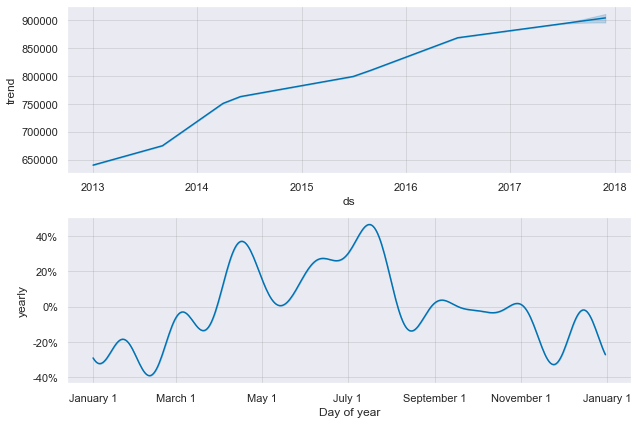

In [73]:
fig2 = m.plot_components(fcst)

In [74]:
preds = fcst[-6:]
preds = preds['yhat'].values
actual = test.y.values

In [75]:
mse = ((preds - actual) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 576433579.83
The Root Mean Squared Error is 24009.03


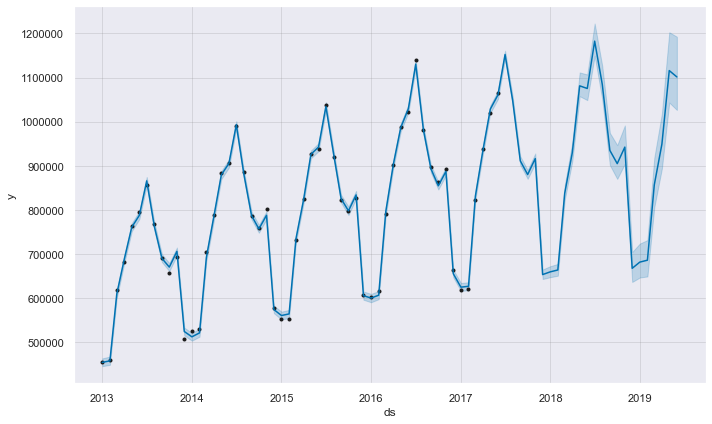

In [76]:
future2 = m.make_future_dataframe(periods=24, freq = 'M')
fcst2 = m.predict(future2)
fig = m.plot(fcst2)

#### Hyperparameter tuning of Prophet

In [77]:
#adding in holidays
import holidays
import random

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2013,2014,2015,2016,2017,2018]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [78]:
holiday.head()

,ds,holiday
0,2013-01-01,US-Holidays
1,2013-01-21,US-Holidays
2,2013-02-18,US-Holidays
3,2013-05-27,US-Holidays
4,2013-07-04,US-Holidays


In [118]:
from sklearn.model_selection import ParameterGrid

test = test.reset_index(drop=True)

params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.05, 0.1, 0.5, 0.8, 1],
              'holidays_prior_scale':[0.05, 0.1, 0.5, 0.8, 1],
              #'n_changepoints' : [10,15,20], #very clear line with very detectable changepoints so will leave it to automatic detection
              }

grid = ParameterGrid(params_grid)
cnt = 0

for p in grid:
    cnt = cnt+1

print('Total Possible Models', cnt)

Total Possible Models 50


In [121]:
strt='2017-07-01'
end='2017-12-01'
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])

for p in tqdm_notebook(grid):
    test_pred = pd.DataFrame()
    random.seed(0)
    train_model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         seasonality_mode = p['seasonality_mode'],
                         holidays = holiday, 
                         interval_width = 0.95,
                         weekly_seasonality=False,
                         daily_seasonality=False)
    train_model.add_country_holidays(country_name = 'US')
    train_model.fit(train)
    train_forecast = train_model.make_future_dataframe(periods = 6, freq = 'M', include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test_pred = train_forecast[['ds','yhat']]
    RMSE = np.sqrt(((abs(test_pred['yhat']) - test['y']) ** 2).mean())
    #MAPE = mean_absolute_percentage_error(test['y'], abs(test_pred['yhat']))
    model_parameters = model_parameters.append({'RMSE':RMSE,'Parameters':p}, ignore_index=True)

In [122]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters
0,22275.337755,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
1,22283.727670,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
2,22377.994659,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
3,22450.237741,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
4,22660.543942,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [123]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 0.1,
 'seasonality_mode': 'additive'}

In [124]:
#setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale = 0.5,
                      holidays_prior_scale = 0.1,
                      seasonality_mode = 'additive',
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


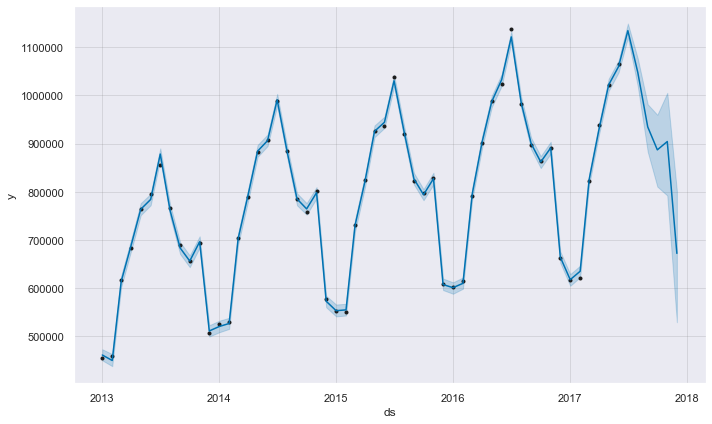

In [125]:
future = final_model.make_future_dataframe(periods=6, freq='M')
fcst_tuned = final_model.predict(future)
fig = final_model.plot(fcst_tuned)

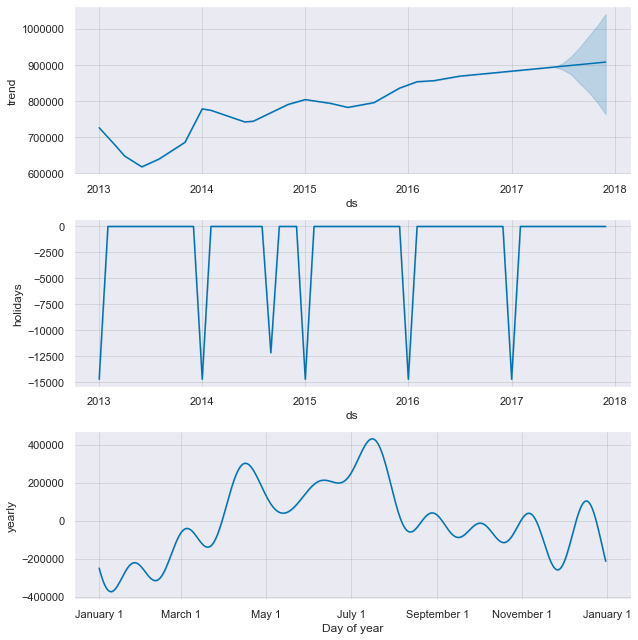

In [126]:
fig2 = final_model.plot_components(fcst_tuned)

In [127]:
preds_tuned = fcst_tuned[-6:]
preds_tuned = preds_tuned['yhat'].values
actual = test.y.values

In [128]:
mse = ((preds_tuned - actual) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 496190672.11
The Root Mean Squared Error is 22275.34


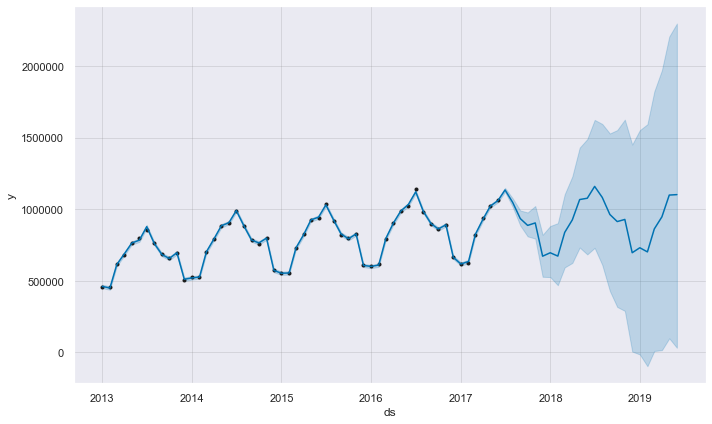

In [129]:
future2_tuned = final_model.make_future_dataframe(periods=24, freq = 'M')
fcst2_tuned = final_model.predict(future2_tuned)
fig = m.plot(fcst2_tuned)

The above shows that SARIMA performs the best, with the lowest RMSE obtained for predicting the test dates sales. Prophet could probably be tuned further to improve forecasts.